In [1]:
import copy
from functools import partial
import gc
from tensorflow import keras
from matplotlib import pyplot as plt
import numpy as np
from uncertainty_testbed.generators.data_generator_explicit import AnalyticBinaryClassGenerator
from uncertainty_testbed.utilities.functions import map_to_constant
from uncertainty_testbed.uncertainty_models.mc_dropout import MCDropoutLayer, MCDropoutKerasClassification

2022-05-07 15:42:15.358837: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-07 15:42:15.358869: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# generate some data
s = partial(map_to_constant, c=0.01)
eg = AnalyticBinaryClassGenerator(seed=42, num_inputs=10, name="cauchy", threshold=0.5,
                                  noise_distribution="cauchy", noise_scale=s)
x, y = eg.generate_labeled(120096)
x = x.astype("float32")
y = y.astype("uint8")
x_train, y_train = x[:33280, :], y[:33280]
x_val, y_val = x[100096:, :], y[100096:]

In [3]:
def opt_name(optimizer):
    return str(optimizer).split("object")[0].split(".")[-1].strip().lower()

optimizer_lookup = {
    opt_name(opt): opt for opt in  
    [keras.optimizers.Nadam(learning_rate=3e-5), 
     keras.optimizers.SGD(learning_rate=5e-3), 
     keras.optimizers.RMSprop(learning_rate=5e-3),
     keras.optimizers.Adam(learning_rate=3e-3),
     keras.optimizers.Adadelta(learning_rate=1e-1),
     keras.optimizers.Adamax(learning_rate=7e-3)]
}

optimal_schedules = [
    {
        "optimizer": keras.optimizers.Nadam(learning_rate=3e-5),
        "learning_rate": 3e-5,
        "batch": 256,
        "epoch": 3*28
    },
    {
        "optimizer": keras.optimizers.SGD(learning_rate=5e-3),
        "learning_rate": 5e-3,
        "batch": 256,
        "epoch": 3*59
    },
    {
        "optimizer": keras.optimizers.SGD(learning_rate=1e-2),
        "learning_rate" :1e-2,
        "batch": 8,
        "epoch": 3*1
    },
    {
        "optimizer": keras.optimizers.RMSprop(learning_rate=5e-3),
        "learning_rate": 5e-3,
        "batch": 8,
        "epoch": 3*1# 0.1781
    },
    {
        "optimizer": keras.optimizers.Adam(learning_rate=3e-3),
        "learning_rate": 3e-3,
        "batch": 8,
        "epoch": 3*1# 0.2076
    },
    {
        "optimizer": keras.optimizers.Adadelta(learning_rate=1e-1),
        "learning_rate": 1e-1,
        "batch": 8,
        "epoch": 3*2# 0.2354
    },
    {
        "optimizer": keras.optimizers.Adamax(learning_rate=7e-3),
        "learning_rate": 7e-3,
        "batch": 8,
        "epoch": 3*1# 0.2249
    },
    {
        "optimizer": keras.optimizers.Nadam(learning_rate=7e-3),
        "learning_rate": 7e-3,
        "batch": 8,
        "epoch": 3*4# 0.1905
    }
]

In [4]:
scan_results = []
champion_params = None
champion_loss = np.inf
for params in optimal_schedules:
    lr = params["learning_rate"]
    for learning_rate in [0.8*lr, lr, 1.2*lr]:
        optimizer = params["optimizer"]
        optimizer.learning_rate.assign(learning_rate)
        num_epochs = int(1.4*params["epoch"] + 2)
        batch_size = int(params["batch"])
        model = keras.Sequential()
        model.add(keras.layers.Dense(60, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(60, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(60, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(1, activation="sigmoid"))
        model.compile(
            optimizer=optimizer,
            loss="binary_crossentropy",
            metrics=["accuracy", "AUC"]
        )
        history = model.fit(
            x_train,
            y_train,
            epochs=num_epochs,
            batch_size=batch_size,
            validation_data=(x_val, y_val),
        )
        
        history_dict = history.history
        val_loss = history_dict["val_loss"]
        val_auc = history_dict["val_auc"]
        val_accuracy = history_dict["val_accuracy"]
        epochs = range(1, len(val_loss)+1)
        
        best_loss = {"loss": val_loss[np.argmin(val_loss)], "epoch": epochs[np.argmin(val_loss)]}
        best_auc = {"auc": val_auc[np.argmax(val_auc)], "epoch": epochs[np.argmax(val_auc)]}
        best_accuracy = {"accuracy": val_accuracy[np.argmax(val_accuracy)], "epoch": epochs[np.argmax(val_accuracy)]}
        
        ps = {k: copy.deepcopy(v) for k, v in params.items() if k not in ["optimizer", "model"]}
        ps["optimizer"] = opt_name(optimizer)
        ps["learning_rate"] = copy.deepcopy(learning_rate)
        ps["best_loss"] = best_loss
        ps["best_auc"] = best_auc
        ps["best_accuracy"] = best_accuracy
        print(ps)
        scan_results.append(ps)
        
        if best_loss["loss"] < champion_loss:
            champion_loss = best_loss["loss"]
            champion_params = {k: copy.deepcopy(v) for k, v in ps.items()}
            champion_params["model"] = keras.models.clone_model(model)
        

model = keras.models.clone_model(champion_params["model"])

Epoch 1/119


2022-05-07 15:42:18.262465: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-07 15:42:18.262500: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-07 15:42:18.262520: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (xps): /proc/driver/nvidia/version does not exist
2022-05-07 15:42:18.262775: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


130/130 [==============================] - 2s 6ms/step - loss: 0.7018 - accuracy: 0.4978 - auc: 0.4942 - val_loss: 0.6938 - val_accuracy: 0.5106 - val_auc: 0.5072
Epoch 2/119
130/130 [==============================] - 0s 3ms/step - loss: 0.6981 - accuracy: 0.5051 - auc: 0.5078 - val_loss: 0.6912 - val_accuracy: 0.5334 - val_auc: 0.5385
Epoch 3/119
130/130 [==============================] - 0s 3ms/step - loss: 0.6952 - accuracy: 0.5160 - auc: 0.5217 - val_loss: 0.6886 - val_accuracy: 0.5527 - val_auc: 0.5698
Epoch 4/119
130/130 [==============================] - 0s 3ms/step - loss: 0.6933 - accuracy: 0.5239 - auc: 0.5308 - val_loss: 0.6862 - val_accuracy: 0.5698 - val_auc: 0.5969
Epoch 5/119
130/130 [==============================] - 0s 3ms/step - loss: 0.6914 - accuracy: 0.5313 - auc: 0.5422 - val_loss: 0.6836 - val_accuracy: 0.5882 - val_auc: 0.6248
Epoch 6/119
130/130 [==============================] - 0s 3ms/step - loss: 0.6893 - accuracy: 0.5359 - auc: 0.5500 - val_loss: 0.6809 - v

Epoch 48/119
130/130 [==============================] - 1s 5ms/step - loss: 0.3711 - accuracy: 0.8330 - auc: 0.9167 - val_loss: 0.2469 - val_accuracy: 0.9380 - val_auc: 0.9853
Epoch 49/119
130/130 [==============================] - 1s 6ms/step - loss: 0.3682 - accuracy: 0.8359 - auc: 0.9184 - val_loss: 0.2429 - val_accuracy: 0.9387 - val_auc: 0.9857
Epoch 50/119
130/130 [==============================] - 1s 5ms/step - loss: 0.3616 - accuracy: 0.8408 - auc: 0.9219 - val_loss: 0.2386 - val_accuracy: 0.9409 - val_auc: 0.9861
Epoch 51/119
130/130 [==============================] - 1s 6ms/step - loss: 0.3594 - accuracy: 0.8398 - auc: 0.9219 - val_loss: 0.2347 - val_accuracy: 0.9416 - val_auc: 0.9864
Epoch 52/119
130/130 [==============================] - 1s 6ms/step - loss: 0.3591 - accuracy: 0.8407 - auc: 0.9222 - val_loss: 0.2311 - val_accuracy: 0.9429 - val_auc: 0.9868
Epoch 53/119
130/130 [==============================] - 1s 8ms/step - loss: 0.3486 - accuracy: 0.8446 - auc: 0.9267 - va

130/130 [==============================] - 0s 4ms/step - loss: 0.2655 - accuracy: 0.8920 - auc: 0.9583 - val_loss: 0.1612 - val_accuracy: 0.9627 - val_auc: 0.9918
Epoch 95/119
130/130 [==============================] - 0s 4ms/step - loss: 0.2668 - accuracy: 0.8931 - auc: 0.9581 - val_loss: 0.1603 - val_accuracy: 0.9629 - val_auc: 0.9918
Epoch 96/119
130/130 [==============================] - 0s 4ms/step - loss: 0.2631 - accuracy: 0.8928 - auc: 0.9589 - val_loss: 0.1592 - val_accuracy: 0.9631 - val_auc: 0.9919
Epoch 97/119
130/130 [==============================] - 0s 4ms/step - loss: 0.2657 - accuracy: 0.8934 - auc: 0.9583 - val_loss: 0.1584 - val_accuracy: 0.9632 - val_auc: 0.9919
Epoch 98/119
130/130 [==============================] - 0s 4ms/step - loss: 0.2698 - accuracy: 0.8903 - auc: 0.9571 - val_loss: 0.1578 - val_accuracy: 0.9637 - val_auc: 0.9920
Epoch 99/119
130/130 [==============================] - 1s 4ms/step - loss: 0.2594 - accuracy: 0.8966 - auc: 0.9605 - val_loss: 0.157

130/130 [==============================] - 0s 3ms/step - loss: 0.4688 - accuracy: 0.7758 - auc: 0.8614 - val_loss: 0.3694 - val_accuracy: 0.8747 - val_auc: 0.9513
Epoch 21/119
130/130 [==============================] - 0s 3ms/step - loss: 0.4596 - accuracy: 0.7798 - auc: 0.8671 - val_loss: 0.3577 - val_accuracy: 0.8792 - val_auc: 0.9549
Epoch 22/119
130/130 [==============================] - 0s 3ms/step - loss: 0.4506 - accuracy: 0.7874 - auc: 0.8731 - val_loss: 0.3464 - val_accuracy: 0.8848 - val_auc: 0.9584
Epoch 23/119
130/130 [==============================] - 0s 3ms/step - loss: 0.4437 - accuracy: 0.7901 - auc: 0.8762 - val_loss: 0.3361 - val_accuracy: 0.8888 - val_auc: 0.9614
Epoch 24/119
130/130 [==============================] - 0s 3ms/step - loss: 0.4379 - accuracy: 0.7952 - auc: 0.8802 - val_loss: 0.3265 - val_accuracy: 0.8931 - val_auc: 0.9641
Epoch 25/119
130/130 [==============================] - 0s 3ms/step - loss: 0.4298 - accuracy: 0.7953 - auc: 0.8840 - val_loss: 0.317

130/130 [==============================] - 0s 3ms/step - loss: 0.2901 - accuracy: 0.8814 - auc: 0.9501 - val_loss: 0.1764 - val_accuracy: 0.9575 - val_auc: 0.9906
Epoch 67/119
130/130 [==============================] - 0s 3ms/step - loss: 0.2886 - accuracy: 0.8821 - auc: 0.9507 - val_loss: 0.1753 - val_accuracy: 0.9584 - val_auc: 0.9907
Epoch 68/119
130/130 [==============================] - 0s 3ms/step - loss: 0.2895 - accuracy: 0.8812 - auc: 0.9502 - val_loss: 0.1741 - val_accuracy: 0.9589 - val_auc: 0.9908
Epoch 69/119
130/130 [==============================] - 0s 3ms/step - loss: 0.2817 - accuracy: 0.8837 - auc: 0.9534 - val_loss: 0.1730 - val_accuracy: 0.9592 - val_auc: 0.9909
Epoch 70/119
130/130 [==============================] - 0s 3ms/step - loss: 0.2828 - accuracy: 0.8846 - auc: 0.9527 - val_loss: 0.1718 - val_accuracy: 0.9596 - val_auc: 0.9910
Epoch 71/119
130/130 [==============================] - 0s 3ms/step - loss: 0.2856 - accuracy: 0.8849 - auc: 0.9520 - val_loss: 0.170

130/130 [==============================] - 0s 3ms/step - loss: 0.2371 - accuracy: 0.9084 - auc: 0.9668 - val_loss: 0.1415 - val_accuracy: 0.9696 - val_auc: 0.9927
Epoch 113/119
130/130 [==============================] - 1s 5ms/step - loss: 0.2344 - accuracy: 0.9088 - auc: 0.9678 - val_loss: 0.1410 - val_accuracy: 0.9696 - val_auc: 0.9928
Epoch 114/119
130/130 [==============================] - 1s 4ms/step - loss: 0.2286 - accuracy: 0.9140 - auc: 0.9696 - val_loss: 0.1403 - val_accuracy: 0.9695 - val_auc: 0.9928
Epoch 115/119
130/130 [==============================] - 0s 4ms/step - loss: 0.2374 - accuracy: 0.9109 - auc: 0.9669 - val_loss: 0.1401 - val_accuracy: 0.9703 - val_auc: 0.9928
Epoch 116/119
130/130 [==============================] - 0s 4ms/step - loss: 0.2303 - accuracy: 0.9125 - auc: 0.9687 - val_loss: 0.1397 - val_accuracy: 0.9703 - val_auc: 0.9928
Epoch 117/119
130/130 [==============================] - 1s 4ms/step - loss: 0.2303 - accuracy: 0.9126 - auc: 0.9688 - val_loss: 

130/130 [==============================] - 1s 4ms/step - loss: 0.3013 - accuracy: 0.8718 - auc: 0.9459 - val_loss: 0.1813 - val_accuracy: 0.9561 - val_auc: 0.9906
Epoch 39/119
130/130 [==============================] - 1s 4ms/step - loss: 0.2992 - accuracy: 0.8745 - auc: 0.9469 - val_loss: 0.1792 - val_accuracy: 0.9576 - val_auc: 0.9907
Epoch 40/119
130/130 [==============================] - 1s 5ms/step - loss: 0.2936 - accuracy: 0.8780 - auc: 0.9494 - val_loss: 0.1773 - val_accuracy: 0.9574 - val_auc: 0.9908
Epoch 41/119
130/130 [==============================] - 1s 5ms/step - loss: 0.2887 - accuracy: 0.8781 - auc: 0.9504 - val_loss: 0.1753 - val_accuracy: 0.9575 - val_auc: 0.9910
Epoch 42/119
130/130 [==============================] - 1s 4ms/step - loss: 0.2899 - accuracy: 0.8810 - auc: 0.9500 - val_loss: 0.1737 - val_accuracy: 0.9579 - val_auc: 0.9910
Epoch 43/119
130/130 [==============================] - 1s 4ms/step - loss: 0.2902 - accuracy: 0.8800 - auc: 0.9501 - val_loss: 0.172

130/130 [==============================] - 1s 5ms/step - loss: 0.2152 - accuracy: 0.9172 - auc: 0.9728 - val_loss: 0.1308 - val_accuracy: 0.9711 - val_auc: 0.9933
Epoch 85/119
130/130 [==============================] - 1s 6ms/step - loss: 0.2178 - accuracy: 0.9173 - auc: 0.9720 - val_loss: 0.1302 - val_accuracy: 0.9713 - val_auc: 0.9933
Epoch 86/119
130/130 [==============================] - 1s 6ms/step - loss: 0.2192 - accuracy: 0.9166 - auc: 0.9715 - val_loss: 0.1296 - val_accuracy: 0.9719 - val_auc: 0.9932
Epoch 87/119
130/130 [==============================] - 1s 7ms/step - loss: 0.2175 - accuracy: 0.9167 - auc: 0.9720 - val_loss: 0.1290 - val_accuracy: 0.9719 - val_auc: 0.9933
Epoch 88/119
130/130 [==============================] - 1s 5ms/step - loss: 0.2071 - accuracy: 0.9209 - auc: 0.9748 - val_loss: 0.1280 - val_accuracy: 0.9720 - val_auc: 0.9934
Epoch 89/119
130/130 [==============================] - 1s 5ms/step - loss: 0.2070 - accuracy: 0.9204 - auc: 0.9746 - val_loss: 0.127

130/130 [==============================] - 1s 4ms/step - loss: 0.6879 - accuracy: 0.5450 - auc: 0.5626 - val_loss: 0.6771 - val_accuracy: 0.6086 - val_auc: 0.6510
Epoch 11/249
130/130 [==============================] - 1s 4ms/step - loss: 0.6865 - accuracy: 0.5458 - auc: 0.5671 - val_loss: 0.6755 - val_accuracy: 0.6170 - val_auc: 0.6612
Epoch 12/249
130/130 [==============================] - 1s 6ms/step - loss: 0.6856 - accuracy: 0.5469 - auc: 0.5689 - val_loss: 0.6738 - val_accuracy: 0.6237 - val_auc: 0.6702
Epoch 13/249
130/130 [==============================] - 1s 4ms/step - loss: 0.6833 - accuracy: 0.5547 - auc: 0.5770 - val_loss: 0.6720 - val_accuracy: 0.6303 - val_auc: 0.6793
Epoch 14/249
130/130 [==============================] - 1s 5ms/step - loss: 0.6810 - accuracy: 0.5583 - auc: 0.5855 - val_loss: 0.6701 - val_accuracy: 0.6355 - val_auc: 0.6876
Epoch 15/249
130/130 [==============================] - 1s 5ms/step - loss: 0.6806 - accuracy: 0.5648 - auc: 0.5885 - val_loss: 0.668

130/130 [==============================] - 1s 6ms/step - loss: 0.4134 - accuracy: 0.8141 - auc: 0.8976 - val_loss: 0.2923 - val_accuracy: 0.9386 - val_auc: 0.9850
Epoch 57/249
130/130 [==============================] - 1s 5ms/step - loss: 0.4061 - accuracy: 0.8151 - auc: 0.9008 - val_loss: 0.2840 - val_accuracy: 0.9408 - val_auc: 0.9857
Epoch 58/249
130/130 [==============================] - 1s 5ms/step - loss: 0.4015 - accuracy: 0.8162 - auc: 0.9024 - val_loss: 0.2764 - val_accuracy: 0.9428 - val_auc: 0.9863
Epoch 59/249
130/130 [==============================] - 1s 6ms/step - loss: 0.3910 - accuracy: 0.8276 - auc: 0.9093 - val_loss: 0.2687 - val_accuracy: 0.9449 - val_auc: 0.9870
Epoch 60/249
130/130 [==============================] - 1s 5ms/step - loss: 0.3881 - accuracy: 0.8270 - auc: 0.9093 - val_loss: 0.2622 - val_accuracy: 0.9463 - val_auc: 0.9874
Epoch 61/249
130/130 [==============================] - 1s 5ms/step - loss: 0.3859 - accuracy: 0.8291 - auc: 0.9107 - val_loss: 0.256

130/130 [==============================] - 1s 4ms/step - loss: 0.2758 - accuracy: 0.8902 - auc: 0.9553 - val_loss: 0.1633 - val_accuracy: 0.9650 - val_auc: 0.9922
Epoch 103/249
130/130 [==============================] - 1s 4ms/step - loss: 0.2762 - accuracy: 0.8933 - auc: 0.9556 - val_loss: 0.1624 - val_accuracy: 0.9661 - val_auc: 0.9923
Epoch 104/249
130/130 [==============================] - 1s 4ms/step - loss: 0.2711 - accuracy: 0.8933 - auc: 0.9570 - val_loss: 0.1616 - val_accuracy: 0.9656 - val_auc: 0.9922
Epoch 105/249
130/130 [==============================] - 1s 6ms/step - loss: 0.2749 - accuracy: 0.8908 - auc: 0.9559 - val_loss: 0.1610 - val_accuracy: 0.9653 - val_auc: 0.9922
Epoch 106/249
130/130 [==============================] - 1s 4ms/step - loss: 0.2728 - accuracy: 0.8946 - auc: 0.9564 - val_loss: 0.1602 - val_accuracy: 0.9660 - val_auc: 0.9923
Epoch 107/249
130/130 [==============================] - 1s 5ms/step - loss: 0.2762 - accuracy: 0.8935 - auc: 0.9556 - val_loss: 

130/130 [==============================] - 1s 5ms/step - loss: 0.2368 - accuracy: 0.9120 - auc: 0.9672 - val_loss: 0.1418 - val_accuracy: 0.9696 - val_auc: 0.9929
Epoch 149/249
130/130 [==============================] - 1s 5ms/step - loss: 0.2378 - accuracy: 0.9090 - auc: 0.9666 - val_loss: 0.1415 - val_accuracy: 0.9702 - val_auc: 0.9930
Epoch 150/249
130/130 [==============================] - 1s 5ms/step - loss: 0.2362 - accuracy: 0.9108 - auc: 0.9673 - val_loss: 0.1410 - val_accuracy: 0.9707 - val_auc: 0.9930
Epoch 151/249
130/130 [==============================] - 1s 5ms/step - loss: 0.2315 - accuracy: 0.9130 - auc: 0.9687 - val_loss: 0.1406 - val_accuracy: 0.9708 - val_auc: 0.9930
Epoch 152/249
130/130 [==============================] - 1s 5ms/step - loss: 0.2343 - accuracy: 0.9116 - auc: 0.9676 - val_loss: 0.1403 - val_accuracy: 0.9710 - val_auc: 0.9930
Epoch 153/249
130/130 [==============================] - 1s 4ms/step - loss: 0.2330 - accuracy: 0.9118 - auc: 0.9680 - val_loss: 

130/130 [==============================] - 1s 5ms/step - loss: 0.2117 - accuracy: 0.9201 - auc: 0.9733 - val_loss: 0.1307 - val_accuracy: 0.9725 - val_auc: 0.9934
Epoch 195/249
130/130 [==============================] - 1s 5ms/step - loss: 0.2093 - accuracy: 0.9202 - auc: 0.9739 - val_loss: 0.1303 - val_accuracy: 0.9726 - val_auc: 0.9934
Epoch 196/249
130/130 [==============================] - 1s 4ms/step - loss: 0.2099 - accuracy: 0.9209 - auc: 0.9739 - val_loss: 0.1301 - val_accuracy: 0.9725 - val_auc: 0.9934
Epoch 197/249
130/130 [==============================] - 1s 5ms/step - loss: 0.2085 - accuracy: 0.9225 - auc: 0.9744 - val_loss: 0.1299 - val_accuracy: 0.9726 - val_auc: 0.9934
Epoch 198/249
130/130 [==============================] - 1s 6ms/step - loss: 0.2074 - accuracy: 0.9217 - auc: 0.9746 - val_loss: 0.1297 - val_accuracy: 0.9729 - val_auc: 0.9934
Epoch 199/249
130/130 [==============================] - 1s 6ms/step - loss: 0.2085 - accuracy: 0.9221 - auc: 0.9741 - val_loss: 

130/130 [==============================] - 1s 4ms/step - loss: 0.1967 - accuracy: 0.9258 - auc: 0.9770 - val_loss: 0.1235 - val_accuracy: 0.9742 - val_auc: 0.9938
Epoch 241/249
130/130 [==============================] - 1s 4ms/step - loss: 0.1975 - accuracy: 0.9250 - auc: 0.9766 - val_loss: 0.1236 - val_accuracy: 0.9733 - val_auc: 0.9937
Epoch 242/249
130/130 [==============================] - 1s 5ms/step - loss: 0.1947 - accuracy: 0.9283 - auc: 0.9774 - val_loss: 0.1237 - val_accuracy: 0.9729 - val_auc: 0.9937
Epoch 243/249
130/130 [==============================] - 0s 4ms/step - loss: 0.1949 - accuracy: 0.9262 - auc: 0.9774 - val_loss: 0.1235 - val_accuracy: 0.9737 - val_auc: 0.9937
Epoch 244/249
130/130 [==============================] - 1s 4ms/step - loss: 0.1972 - accuracy: 0.9252 - auc: 0.9769 - val_loss: 0.1236 - val_accuracy: 0.9733 - val_auc: 0.9937
Epoch 245/249
130/130 [==============================] - 1s 4ms/step - loss: 0.1888 - accuracy: 0.9288 - auc: 0.9787 - val_loss: 

130/130 [==============================] - 1s 4ms/step - loss: 0.6440 - accuracy: 0.6320 - auc: 0.6899 - val_loss: 0.6211 - val_accuracy: 0.7173 - val_auc: 0.8103
Epoch 37/249
130/130 [==============================] - 1s 4ms/step - loss: 0.6402 - accuracy: 0.6322 - auc: 0.6937 - val_loss: 0.6144 - val_accuracy: 0.7282 - val_auc: 0.8207
Epoch 38/249
130/130 [==============================] - 1s 4ms/step - loss: 0.6353 - accuracy: 0.6391 - auc: 0.7017 - val_loss: 0.6071 - val_accuracy: 0.7382 - val_auc: 0.8310
Epoch 39/249
130/130 [==============================] - 1s 4ms/step - loss: 0.6304 - accuracy: 0.6452 - auc: 0.7117 - val_loss: 0.5992 - val_accuracy: 0.7484 - val_auc: 0.8405
Epoch 40/249
130/130 [==============================] - 1s 4ms/step - loss: 0.6243 - accuracy: 0.6552 - auc: 0.7228 - val_loss: 0.5906 - val_accuracy: 0.7589 - val_auc: 0.8512
Epoch 41/249
130/130 [==============================] - 1s 4ms/step - loss: 0.6175 - accuracy: 0.6630 - auc: 0.7323 - val_loss: 0.581

130/130 [==============================] - 1s 5ms/step - loss: 0.3144 - accuracy: 0.8701 - auc: 0.9417 - val_loss: 0.1894 - val_accuracy: 0.9601 - val_auc: 0.9911
Epoch 83/249
130/130 [==============================] - 1s 6ms/step - loss: 0.3147 - accuracy: 0.8708 - auc: 0.9421 - val_loss: 0.1873 - val_accuracy: 0.9610 - val_auc: 0.9913
Epoch 84/249
130/130 [==============================] - 1s 8ms/step - loss: 0.3023 - accuracy: 0.8769 - auc: 0.9467 - val_loss: 0.1847 - val_accuracy: 0.9614 - val_auc: 0.9914
Epoch 85/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3027 - accuracy: 0.8784 - auc: 0.9467 - val_loss: 0.1825 - val_accuracy: 0.9622 - val_auc: 0.9914
Epoch 86/249
130/130 [==============================] - 1s 4ms/step - loss: 0.2988 - accuracy: 0.8797 - auc: 0.9475 - val_loss: 0.1803 - val_accuracy: 0.9625 - val_auc: 0.9915
Epoch 87/249
130/130 [==============================] - 1s 4ms/step - loss: 0.2986 - accuracy: 0.8813 - auc: 0.9482 - val_loss: 0.178

130/130 [==============================] - 1s 5ms/step - loss: 0.2376 - accuracy: 0.9095 - auc: 0.9667 - val_loss: 0.1426 - val_accuracy: 0.9657 - val_auc: 0.9925
Epoch 129/249
130/130 [==============================] - 1s 5ms/step - loss: 0.2403 - accuracy: 0.9086 - auc: 0.9663 - val_loss: 0.1420 - val_accuracy: 0.9669 - val_auc: 0.9926
Epoch 130/249
130/130 [==============================] - 1s 5ms/step - loss: 0.2417 - accuracy: 0.9071 - auc: 0.9656 - val_loss: 0.1419 - val_accuracy: 0.9661 - val_auc: 0.9925
Epoch 131/249
130/130 [==============================] - 1s 6ms/step - loss: 0.2393 - accuracy: 0.9096 - auc: 0.9664 - val_loss: 0.1413 - val_accuracy: 0.9664 - val_auc: 0.9925
Epoch 132/249
130/130 [==============================] - 1s 5ms/step - loss: 0.2410 - accuracy: 0.9093 - auc: 0.9661 - val_loss: 0.1408 - val_accuracy: 0.9670 - val_auc: 0.9926
Epoch 133/249
130/130 [==============================] - 1s 5ms/step - loss: 0.2352 - accuracy: 0.9115 - auc: 0.9676 - val_loss: 

130/130 [==============================] - 1s 6ms/step - loss: 0.2112 - accuracy: 0.9211 - auc: 0.9735 - val_loss: 0.1269 - val_accuracy: 0.9717 - val_auc: 0.9934
Epoch 175/249
130/130 [==============================] - 1s 4ms/step - loss: 0.2070 - accuracy: 0.9214 - auc: 0.9745 - val_loss: 0.1265 - val_accuracy: 0.9722 - val_auc: 0.9934
Epoch 176/249
130/130 [==============================] - 1s 6ms/step - loss: 0.2094 - accuracy: 0.9212 - auc: 0.9738 - val_loss: 0.1263 - val_accuracy: 0.9720 - val_auc: 0.9935
Epoch 177/249
130/130 [==============================] - 1s 6ms/step - loss: 0.2066 - accuracy: 0.9229 - auc: 0.9746 - val_loss: 0.1261 - val_accuracy: 0.9718 - val_auc: 0.9934
Epoch 178/249
130/130 [==============================] - 1s 4ms/step - loss: 0.2118 - accuracy: 0.9197 - auc: 0.9734 - val_loss: 0.1259 - val_accuracy: 0.9719 - val_auc: 0.9935
Epoch 179/249
130/130 [==============================] - 1s 5ms/step - loss: 0.2059 - accuracy: 0.9215 - auc: 0.9748 - val_loss: 

130/130 [==============================] - 0s 4ms/step - loss: 0.1851 - accuracy: 0.9316 - auc: 0.9795 - val_loss: 0.1179 - val_accuracy: 0.9753 - val_auc: 0.9940
Epoch 221/249
130/130 [==============================] - 0s 3ms/step - loss: 0.1862 - accuracy: 0.9305 - auc: 0.9791 - val_loss: 0.1177 - val_accuracy: 0.9754 - val_auc: 0.9940
Epoch 222/249
130/130 [==============================] - 0s 4ms/step - loss: 0.1858 - accuracy: 0.9312 - auc: 0.9792 - val_loss: 0.1175 - val_accuracy: 0.9748 - val_auc: 0.9940
Epoch 223/249
130/130 [==============================] - 0s 3ms/step - loss: 0.1875 - accuracy: 0.9299 - auc: 0.9790 - val_loss: 0.1173 - val_accuracy: 0.9748 - val_auc: 0.9940
Epoch 224/249
130/130 [==============================] - 0s 4ms/step - loss: 0.1848 - accuracy: 0.9296 - auc: 0.9795 - val_loss: 0.1172 - val_accuracy: 0.9746 - val_auc: 0.9940
Epoch 225/249
130/130 [==============================] - 0s 3ms/step - loss: 0.1879 - accuracy: 0.9304 - auc: 0.9786 - val_loss: 

130/130 [==============================] - 1s 4ms/step - loss: 0.6565 - accuracy: 0.5993 - auc: 0.6503 - val_loss: 0.6361 - val_accuracy: 0.6759 - val_auc: 0.7563
Epoch 17/249
130/130 [==============================] - 1s 4ms/step - loss: 0.6527 - accuracy: 0.6056 - auc: 0.6574 - val_loss: 0.6299 - val_accuracy: 0.6849 - val_auc: 0.7671
Epoch 18/249
130/130 [==============================] - 1s 4ms/step - loss: 0.6473 - accuracy: 0.6128 - auc: 0.6690 - val_loss: 0.6229 - val_accuracy: 0.6959 - val_auc: 0.7781
Epoch 19/249
130/130 [==============================] - 1s 4ms/step - loss: 0.6426 - accuracy: 0.6196 - auc: 0.6774 - val_loss: 0.6155 - val_accuracy: 0.7062 - val_auc: 0.7903
Epoch 20/249
130/130 [==============================] - 1s 4ms/step - loss: 0.6369 - accuracy: 0.6278 - auc: 0.6874 - val_loss: 0.6074 - val_accuracy: 0.7167 - val_auc: 0.8032
Epoch 21/249
130/130 [==============================] - 1s 4ms/step - loss: 0.6300 - accuracy: 0.6356 - auc: 0.7007 - val_loss: 0.598

130/130 [==============================] - 1s 4ms/step - loss: 0.3088 - accuracy: 0.8760 - auc: 0.9447 - val_loss: 0.1851 - val_accuracy: 0.9618 - val_auc: 0.9918
Epoch 63/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3041 - accuracy: 0.8766 - auc: 0.9464 - val_loss: 0.1827 - val_accuracy: 0.9621 - val_auc: 0.9918
Epoch 64/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3058 - accuracy: 0.8767 - auc: 0.9454 - val_loss: 0.1808 - val_accuracy: 0.9631 - val_auc: 0.9918
Epoch 65/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3033 - accuracy: 0.8757 - auc: 0.9465 - val_loss: 0.1788 - val_accuracy: 0.9631 - val_auc: 0.9919
Epoch 66/249
130/130 [==============================] - 1s 4ms/step - loss: 0.3005 - accuracy: 0.8806 - auc: 0.9477 - val_loss: 0.1771 - val_accuracy: 0.9638 - val_auc: 0.9920
Epoch 67/249
130/130 [==============================] - 1s 4ms/step - loss: 0.2925 - accuracy: 0.8820 - auc: 0.9502 - val_loss: 0.175

130/130 [==============================] - 1s 4ms/step - loss: 0.2217 - accuracy: 0.9200 - auc: 0.9713 - val_loss: 0.1314 - val_accuracy: 0.9729 - val_auc: 0.9935
Epoch 109/249
130/130 [==============================] - 1s 4ms/step - loss: 0.2237 - accuracy: 0.9179 - auc: 0.9710 - val_loss: 0.1308 - val_accuracy: 0.9733 - val_auc: 0.9936
Epoch 110/249
130/130 [==============================] - 0s 4ms/step - loss: 0.2172 - accuracy: 0.9225 - auc: 0.9723 - val_loss: 0.1301 - val_accuracy: 0.9736 - val_auc: 0.9936
Epoch 111/249
130/130 [==============================] - 1s 4ms/step - loss: 0.2201 - accuracy: 0.9202 - auc: 0.9716 - val_loss: 0.1296 - val_accuracy: 0.9737 - val_auc: 0.9936
Epoch 112/249
130/130 [==============================] - 1s 4ms/step - loss: 0.2144 - accuracy: 0.9224 - auc: 0.9733 - val_loss: 0.1287 - val_accuracy: 0.9739 - val_auc: 0.9937
Epoch 113/249
130/130 [==============================] - 1s 5ms/step - loss: 0.2169 - accuracy: 0.9205 - auc: 0.9723 - val_loss: 

130/130 [==============================] - 1s 4ms/step - loss: 0.1735 - accuracy: 0.9382 - auc: 0.9820 - val_loss: 0.1077 - val_accuracy: 0.9801 - val_auc: 0.9942
Epoch 155/249
130/130 [==============================] - 1s 4ms/step - loss: 0.1745 - accuracy: 0.9392 - auc: 0.9818 - val_loss: 0.1074 - val_accuracy: 0.9806 - val_auc: 0.9942
Epoch 156/249
130/130 [==============================] - 1s 4ms/step - loss: 0.1745 - accuracy: 0.9397 - auc: 0.9815 - val_loss: 0.1071 - val_accuracy: 0.9807 - val_auc: 0.9942
Epoch 157/249
130/130 [==============================] - 1s 4ms/step - loss: 0.1748 - accuracy: 0.9380 - auc: 0.9816 - val_loss: 0.1067 - val_accuracy: 0.9804 - val_auc: 0.9942
Epoch 158/249
130/130 [==============================] - 1s 4ms/step - loss: 0.1719 - accuracy: 0.9405 - auc: 0.9823 - val_loss: 0.1064 - val_accuracy: 0.9804 - val_auc: 0.9942
Epoch 159/249
130/130 [==============================] - 1s 4ms/step - loss: 0.1715 - accuracy: 0.9400 - auc: 0.9822 - val_loss: 

130/130 [==============================] - 1s 4ms/step - loss: 0.1475 - accuracy: 0.9494 - auc: 0.9863 - val_loss: 0.0936 - val_accuracy: 0.9833 - val_auc: 0.9944
Epoch 201/249
130/130 [==============================] - 1s 5ms/step - loss: 0.1463 - accuracy: 0.9499 - auc: 0.9866 - val_loss: 0.0934 - val_accuracy: 0.9834 - val_auc: 0.9945
Epoch 202/249
130/130 [==============================] - 1s 4ms/step - loss: 0.1486 - accuracy: 0.9502 - auc: 0.9860 - val_loss: 0.0931 - val_accuracy: 0.9836 - val_auc: 0.9945
Epoch 203/249
130/130 [==============================] - 1s 4ms/step - loss: 0.1465 - accuracy: 0.9506 - auc: 0.9866 - val_loss: 0.0928 - val_accuracy: 0.9839 - val_auc: 0.9945
Epoch 204/249
130/130 [==============================] - 1s 4ms/step - loss: 0.1469 - accuracy: 0.9501 - auc: 0.9862 - val_loss: 0.0927 - val_accuracy: 0.9839 - val_auc: 0.9945
Epoch 205/249
130/130 [==============================] - 1s 4ms/step - loss: 0.1433 - accuracy: 0.9512 - auc: 0.9872 - val_loss: 

130/130 [==============================] - 1s 5ms/step - loss: 0.1323 - accuracy: 0.9554 - auc: 0.9887 - val_loss: 0.0847 - val_accuracy: 0.9844 - val_auc: 0.9947
Epoch 247/249
130/130 [==============================] - 1s 4ms/step - loss: 0.1313 - accuracy: 0.9567 - auc: 0.9888 - val_loss: 0.0845 - val_accuracy: 0.9845 - val_auc: 0.9947
Epoch 248/249
130/130 [==============================] - 1s 4ms/step - loss: 0.1297 - accuracy: 0.9573 - auc: 0.9890 - val_loss: 0.0843 - val_accuracy: 0.9844 - val_auc: 0.9947
Epoch 249/249
130/130 [==============================] - 1s 4ms/step - loss: 0.1317 - accuracy: 0.9563 - auc: 0.9889 - val_loss: 0.0841 - val_accuracy: 0.9847 - val_auc: 0.9947
{'learning_rate': 0.006, 'batch': 256, 'epoch': 177, 'optimizer': 'sgd', 'best_loss': {'loss': 0.08408867567777634, 'epoch': 249}, 'best_auc': {'auc': 0.9946925044059753, 'epoch': 246}, 'best_accuracy': {'accuracy': 0.9849500060081482, 'epoch': 244}}
Epoch 1/6
4160/4160 [==============================] - 

4160/4160 [==============================] - 15s 4ms/step - loss: 0.2512 - accuracy: 0.9333 - auc: 0.9761 - val_loss: 0.1913 - val_accuracy: 0.9571 - val_auc: 0.9874
Epoch 6/6
4160/4160 [==============================] - 17s 4ms/step - loss: 0.2572 - accuracy: 0.9374 - auc: 0.9769 - val_loss: 0.1618 - val_accuracy: 0.9542 - val_auc: 0.9878
{'learning_rate': 0.006, 'batch': 8, 'epoch': 3, 'optimizer': 'rmsprop', 'best_loss': {'loss': 0.14739970862865448, 'epoch': 2}, 'best_auc': {'auc': 0.9880088567733765, 'epoch': 2}, 'best_accuracy': {'accuracy': 0.9570500254631042, 'epoch': 5}}
Epoch 1/6
4160/4160 [==============================] - 18s 4ms/step - loss: 0.2502 - accuracy: 0.8958 - auc: 0.9633 - val_loss: 0.1335 - val_accuracy: 0.9456 - val_auc: 0.9896
Epoch 2/6
4160/4160 [==============================] - 17s 4ms/step - loss: 0.1494 - accuracy: 0.9456 - auc: 0.9856 - val_loss: 0.1114 - val_accuracy: 0.9621 - val_auc: 0.9924
Epoch 3/6
4160/4160 [==============================] - 16s 4m

4160/4160 [==============================] - 16s 4ms/step - loss: 0.2406 - accuracy: 0.9085 - auc: 0.9661 - val_loss: 0.1321 - val_accuracy: 0.9667 - val_auc: 0.9925
{'learning_rate': 0.1, 'batch': 8, 'epoch': 6, 'optimizer': 'adadelta', 'best_loss': {'loss': 0.13208343088626862, 'epoch': 10}, 'best_auc': {'auc': 0.992535412311554, 'epoch': 10}, 'best_accuracy': {'accuracy': 0.96670001745224, 'epoch': 10}}
Epoch 1/10
4160/4160 [==============================] - 17s 4ms/step - loss: 0.6611 - accuracy: 0.5904 - auc: 0.6353 - val_loss: 0.5379 - val_accuracy: 0.8062 - val_auc: 0.8965
Epoch 2/10
4160/4160 [==============================] - 16s 4ms/step - loss: 0.4932 - accuracy: 0.7576 - auc: 0.8429 - val_loss: 0.3022 - val_accuracy: 0.9075 - val_auc: 0.9738
Epoch 3/10
4160/4160 [==============================] - 16s 4ms/step - loss: 0.3909 - accuracy: 0.8218 - auc: 0.9065 - val_loss: 0.2281 - val_accuracy: 0.9384 - val_auc: 0.9844
Epoch 4/10
4160/4160 [==============================] - 17s

4160/4160 [==============================] - 17s 4ms/step - loss: 0.1956 - accuracy: 0.9299 - auc: 0.9793 - val_loss: 0.1537 - val_accuracy: 0.9581 - val_auc: 0.9911
Epoch 12/18
4160/4160 [==============================] - 16s 4ms/step - loss: 0.1985 - accuracy: 0.9288 - auc: 0.9798 - val_loss: 0.1361 - val_accuracy: 0.9540 - val_auc: 0.9905
Epoch 13/18
4160/4160 [==============================] - 16s 4ms/step - loss: 0.1946 - accuracy: 0.9289 - auc: 0.9799 - val_loss: 0.1290 - val_accuracy: 0.9614 - val_auc: 0.9917
Epoch 14/18
4160/4160 [==============================] - 17s 4ms/step - loss: 0.1956 - accuracy: 0.9307 - auc: 0.9799 - val_loss: 0.1410 - val_accuracy: 0.9566 - val_auc: 0.9914
Epoch 15/18
4160/4160 [==============================] - 16s 4ms/step - loss: 0.1947 - accuracy: 0.9305 - auc: 0.9801 - val_loss: 0.1571 - val_accuracy: 0.9434 - val_auc: 0.9886
Epoch 16/18
4160/4160 [==============================] - 17s 4ms/step - loss: 0.1950 - accuracy: 0.9303 - auc: 0.9798 - va

4160/4160 [==============================] - 16s 4ms/step - loss: 0.1837 - accuracy: 0.9489 - auc: 0.9799 - val_loss: 0.1240 - val_accuracy: 0.9689 - val_auc: 0.9919
{'learning_rate': 0.0084, 'batch': 8, 'epoch': 12, 'optimizer': 'nadam', 'best_loss': {'loss': 0.10755821317434311, 'epoch': 10}, 'best_auc': {'auc': 0.9920688271522522, 'epoch': 5}, 'best_accuracy': {'accuracy': 0.9690999984741211, 'epoch': 11}}


In [5]:
optimizer = optimizer_lookup[champion_params["optimizer"]]
learning_rate = champion_params["learning_rate"]
optimizer.learning_rate.assign(learning_rate)
batch_size = champion_params["batch"]
num_epochs = champion_params["best_loss"]["epoch"]

# train a Keras MLP
model = keras.Sequential()
model.add(keras.layers.Dense(60, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(60, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(60, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(1, activation="sigmoid"))
model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy", "AUC"]
)
history = model.fit(
    x_train,
    y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)

Epoch 1/6
4160/4160 [==============================] - 18s 4ms/step - loss: 0.2508 - accuracy: 0.8948 - auc: 0.9629 - val_loss: 0.1081 - val_accuracy: 0.9651 - val_auc: 0.9928
Epoch 2/6
4160/4160 [==============================] - 18s 4ms/step - loss: 0.1246 - accuracy: 0.9563 - auc: 0.9894 - val_loss: 0.0895 - val_accuracy: 0.9704 - val_auc: 0.9935
Epoch 3/6
4160/4160 [==============================] - 17s 4ms/step - loss: 0.1057 - accuracy: 0.9654 - auc: 0.9913 - val_loss: 0.0745 - val_accuracy: 0.9754 - val_auc: 0.9949
Epoch 4/6
4160/4160 [==============================] - 17s 4ms/step - loss: 0.0955 - accuracy: 0.9690 - auc: 0.9925 - val_loss: 0.0727 - val_accuracy: 0.9779 - val_auc: 0.9944
Epoch 5/6
4160/4160 [==============================] - 16s 4ms/step - loss: 0.0929 - accuracy: 0.9703 - auc: 0.9926 - val_loss: 0.0746 - val_accuracy: 0.9765 - val_auc: 0.9948
Epoch 6/6
4160/4160 [==============================] - 15s 4ms/step - loss: 0.0891 - accuracy: 0.9715 - auc: 0.9927 - va

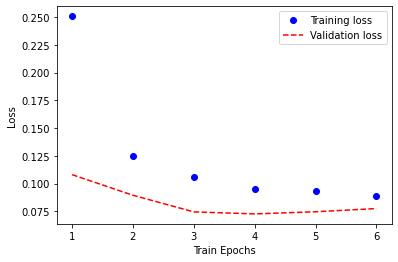

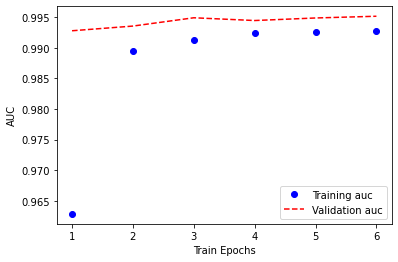

In [6]:
# inspect metrics
history_dict = history.history
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]
auc = history_dict["auc"]
val_auc = history_dict["val_auc"]
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "r--", label="Validation loss")
plt.xlabel("Train Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(epochs, auc, "bo", label="Training auc")
plt.plot(epochs, val_auc, "r--", label="Validation auc")
plt.xlabel("Train Epochs")
plt.ylabel("AUC")
plt.legend()
plt.show()

In [7]:
n = 5
s = 100

p = model.predict(x_val[:1000,:])[:, 0]

scores = eg.get_scores(x_val[:1000,:])
ix_srt = np.argsort(scores)

probs = eg.get_probabilities(x_val[:1000,:])[1]

p = np.convolve(p[ix_srt[::-1]], np.ones(n)/n, mode='valid')
scores = np.convolve(scores[ix_srt[::-1]], np.ones(n)/n, mode='valid')
probs = np.convolve(probs[ix_srt[::-1]], np.ones(n)/n, mode='valid')

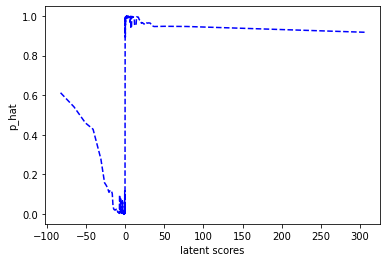

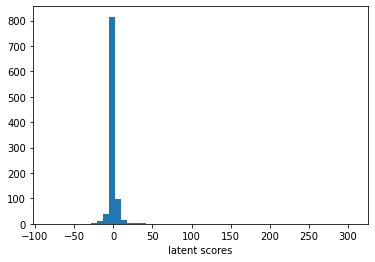

In [8]:
plt.plot(scores, p, '--b')
plt.xlabel('latent scores')
plt.ylabel('p_hat')
plt.show()

plt.hist(scores, bins=50)
plt.xlabel('latent scores')
plt.show()

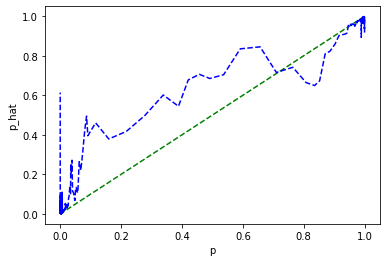

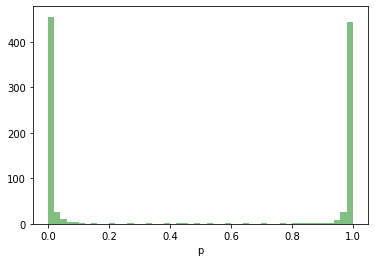

In [9]:
plt.plot(probs, probs, '--g')
plt.plot(probs, p, '--b')
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

plt.hist(probs, bins=50, color='g', alpha=0.5)
plt.xlabel('p')
plt.show()

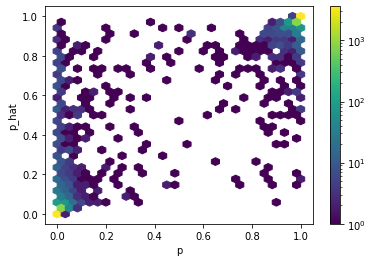

In [10]:
n = 1
s = 100

p = model.predict(x_val[:10000,:])[:, 0]

scores = eg.get_scores(x_val[:10000,:])

probs = eg.get_probabilities(x_val[:10000,:])[1]

plt.hexbin(probs, p, gridsize=30, bins='log')
plt.colorbar()
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

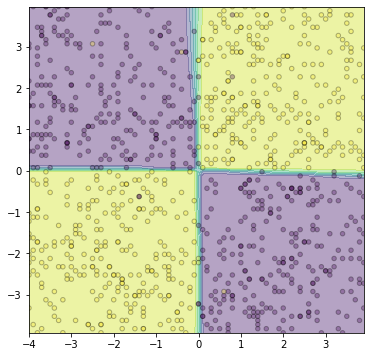

In [11]:
# Plot decision regions
I, J = 2, 6
x_min, x_max = x_val[:, I].min(), x_val[:, I].max()
y_min, y_max = x_val[:, J].min(), x_val[:, J].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
xxyy = np.c_[xx.ravel(), yy.ravel()]
x_ = 0. * np.ones((xxyy.shape[0], 10))
x_[:, I] = xxyy[:, 0]
x_[:, J] = xxyy[:, 1]
z = model.predict(x_)
z = z.reshape(xx.shape)
y_ = eg.get_labels(x_)

fig = plt.figure(figsize=(6,6))
ax = fig.gca()
ax.contourf(xx, yy, z, alpha=0.4)
ixs = np.random.randint(0, y_.shape[0]-1, 1000)
ax.scatter(x_[ixs, I], x_[ixs, J], c=y_[ixs], s=20, alpha=0.3, edgecolor="k")
plt.show()

#model.summary()

In [12]:
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_96 (Dense)            (None, 60)                660       
                                                                 
 dropout_72 (Dropout)        (None, 60)                0         
                                                                 
 dense_97 (Dense)            (None, 60)                3660      
                                                                 
 dropout_73 (Dropout)        (None, 60)                0         
                                                                 
 dense_98 (Dense)            (None, 60)                3660      
                                                                 
 dropout_74 (Dropout)        (None, 60)                0         
                                                                 
 dense_99 (Dense)            (None, 1)               

In [13]:
champion_params

{'learning_rate': 0.0084,
 'batch': 8,
 'epoch': 3,
 'optimizer': 'adamax',
 'best_loss': {'loss': 0.07201100885868073, 'epoch': 6},
 'best_auc': {'auc': 0.9951503872871399, 'epoch': 5},
 'best_accuracy': {'accuracy': 0.9778000116348267, 'epoch': 6},
 'model': <keras.engine.sequential.Sequential at 0x7fbf2d5acc70>}

In [14]:
scan_results

[{'learning_rate': 2.4e-05,
  'batch': 256,
  'epoch': 84,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.14198032021522522, 'epoch': 119},
  'best_auc': {'auc': 0.9927752614021301, 'epoch': 119},
  'best_accuracy': {'accuracy': 0.9685999751091003, 'epoch': 119}},
 {'learning_rate': 3e-05,
  'batch': 256,
  'epoch': 84,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.1379159539937973, 'epoch': 119},
  'best_auc': {'auc': 0.9929078221321106, 'epoch': 119},
  'best_accuracy': {'accuracy': 0.9706000089645386, 'epoch': 119}},
 {'learning_rate': 3.6e-05,
  'batch': 256,
  'epoch': 84,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.11006119102239609, 'epoch': 119},
  'best_auc': {'auc': 0.9938499331474304, 'epoch': 119},
  'best_accuracy': {'accuracy': 0.9773499965667725, 'epoch': 116}},
 {'learning_rate': 0.004,
  'batch': 256,
  'epoch': 177,
  'optimizer': 'sgd',
  'best_loss': {'loss': 0.12235062569379807, 'epoch': 249},
  'best_auc': {'auc': 0.9938268065452576, 'epoch': 248},
  

### Tuning notes: 

Data: train 100096 / val 20000

--
* model: 30, 0.25, 30, 0.25, 30, 0.25, 30, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 80/80 **val_loss: 0.4221** - val_accuracy: 0.7657 - val_auc: 0.9857

--
* model: 30, 0.25, 30, 0.25, 30, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 60/80 **val_loss: 0.3241** - val_accuracy: 0.8463 - val_auc: 0.9856

--
* model: 40, 0.25, 40, 0.25, 40, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 40/80 **val_loss: 0.2726** - val_accuracy: 0.8848 - val_auc: 0.9889

--
* model: 50, 0.25, 50, 0.25, 50, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 38/80 **val_loss: 0.2555** - val_accuracy: 0.8832 - val_auc: 0.9916

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 28/80 **val_loss: 0.2552** - val_accuracy: 0.8909 - val_auc: 0.9929

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / Nadam lr: 2e-5
* Epoch: 48/80 **0.2557** - val_accuracy: 0.8771 - val_auc: 0.9935

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 20, 0.25, 6, 0.25, 1/ batch: 256 / Nadam lr: 2e-5
* Epoch: 47/80 **0.3482** - val_accuracy: 0.8346 - val_auc: 0.9910

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / SGD lr: 5e-3
* Epoch: 59/80 **0.2176** - val_accuracy: 0.8953 - val_auc: 0.9961

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / SGD lr: 3e-3
* Epoch: 80/100 **0.2205** - val_accuracy: 0.8970 - val_auc: 0.9951

--
8/1e-2=> 0.2021 - val_accuracy: 0.9207 - val_auc: 0.9904
8/8e-3=> 0.26...
8/1.3e-2=> 0.25